Text(0.5, 1.0, 'Validation')

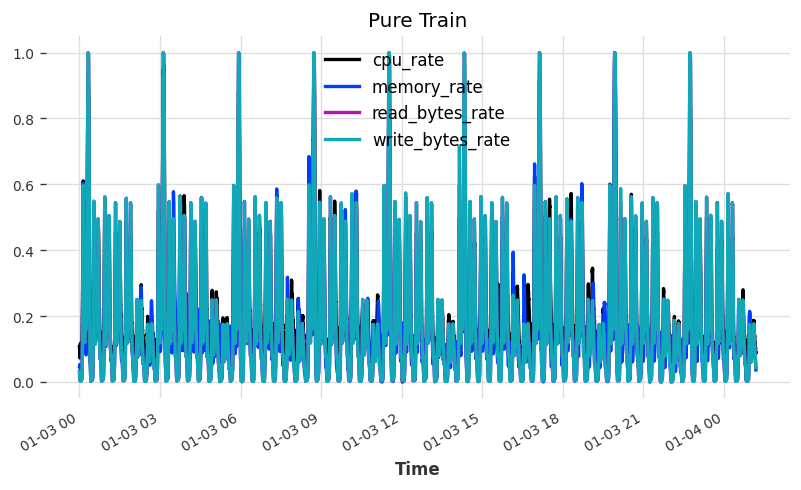

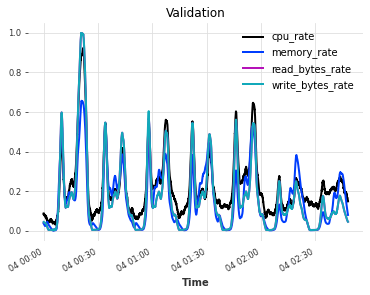

In [1]:
import torch
import numpy as np
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append("../../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune
import os
from matplotlib.pyplot import figure

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

figure(figsize=(8, 4), dpi=120)


dl =  DatasetLoader( '../../pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    resample_freq="1s", augment=False, shift_df_datetime="2022-01-03 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_first = 9*scaled_one_week
train = dl.series_scaled[:idx_first]
val = dl.series_scaled[idx_first:]
# train , val=  dl.get_train_val_by_date(train_end="2022-01-07 00:00:00")
# val = val[:-1]
# tmp_train = train.copy()
# for _ in range(6):
#     train = dl.series_append(train, tmp_train)
    
# train = dl.simple_add_augment(train, -0.01, 0.025, 0.005)

    
train.plot()
plt.title("Pure Train")
val = dl.shift_series_to(val, "2022-04-04 00:00:00")

val.plot(new_plot=True)
plt.title("Validation")



In [2]:
def training_function(config):
    
    def generate_encoders(idxs):
        days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
        encoders = []
        for day in days:
            if day == 0:
                encoders.append(1)
            elif day == 1 or day == 2 or day == 3 or day == 4: 
                encoders.append(2)
            elif day == 5 or day == 6:
                encoders.append(3)
        return encoders
    
    quantiles = [0.1, 0.5, 0.9]

    model = BlockRNNModel(
        model="LSTM",
        input_chunk_length=config["input_chunk_length"],
        output_chunk_length=config["output_chunk_length"],
        hidden_size=config["hidden_size"],
#         n_rnn_layers=config["n_rnn_layers"],
        n_rnn_layers = 2 ,
        batch_size=config["batch_size"],
        n_epochs=51,
        dropout=config["dropout"],
         add_encoders={
        'cyclic': {'past': ['dayofweek', 'hour', 'minute', 'second']},
        'custom': {'past': [generate_encoders]},
        'transformer': Scaler()
        },
        likelihood=QuantileRegression(
            quantiles=quantiles
        ), 
        work_dir=".",
        nr_epochs_val_period=1,
        optimizer_kwargs={"lr": 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True,
        torch_device_str='cuda:0'
        )
    
    
    model.fit(train, val_series=val)
    
    pred = model.predict(series=val[:config["input_chunk_length"]], n=24*60, num_samples=100)
    rr = 0.0
    for rho in quantiles:
        rr += rho_risk(val[config["input_chunk_length"]:], pred, rho=rho)
    rr = rr / len(quantiles)
    
    tune.report(mean_loss=rr)

In [3]:
max_concurrent_trials = 4
analysis = tune.run(
    training_function,
    max_concurrent_trials=max_concurrent_trials,
    resources_per_trial={'cpu': 8.0/max_concurrent_trials, 'gpu': 1.0/max_concurrent_trials},
    local_dir="logs/lstm_hparam",
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    config={
        "input_chunk_length": tune.grid_search([300, 600]),
        "output_chunk_length": tune.grid_search([300, 600]),
        "hidden_size": tune.grid_search([25, 75]),
#         "n_rnn_layers": tune.grid_search([2]),
        "batch_size": tune.grid_search([512]),
        "dropout": tune.grid_search([0.1]),
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [61]:
pred = dl.scaler.inverse_transform(pred)